# Urban Sound Classification

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import sys
from tqdm import tqdm
import IPython
import math
import pickle
import random
from datetime import datetime


In [ ]:
pip install keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=472fae1d9327f2755c98ff2fee3817fc55928cec5afbd35e1ceca75084257548
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [17]:
from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
import os
import librosa
import librosa.display
import glob 
import skimage

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
%cd /content/drive/My\ Drive/UrbanSoundsClassification

/content/drive/My Drive/UrbanSoundsClassification


In [44]:
df = pd.read_csv("UrbanSound8K.csv")
df.shape


(8732, 8)

In [45]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [48]:
import os
import IPython.display as ipd
%cd /content/drive/My\ Drive/UrbanSoundsClassification/urbansoundfolders
ipd.Audio('fold9/101729-0-0-18.wav')

/content/drive/My Drive/UrbanSoundsClassification/urbansoundfolders


In [49]:
df["fold"].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

In [50]:
appended = []
for i in range(1,11):
    appended.append(df[df.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,dog_bark,children_playing,street_music,air_conditioner,drilling,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


In [51]:
df['class'].value_counts(normalize=True)

dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
engine_idling       0.114521
jackhammer          0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: class, dtype: float64

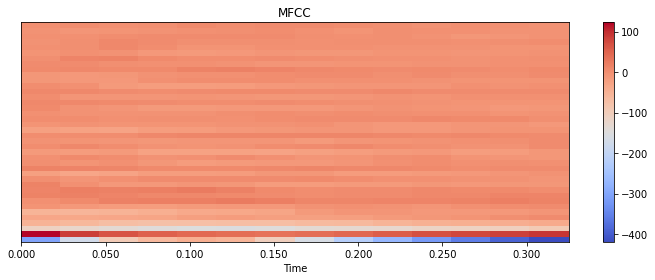

In [53]:
#MFCC 
y,sr=librosa.load("fold5/100032-3-0-0.wav")
mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

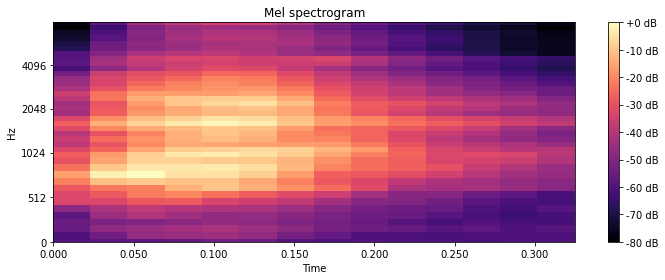

In [54]:
#Melspectrogram
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

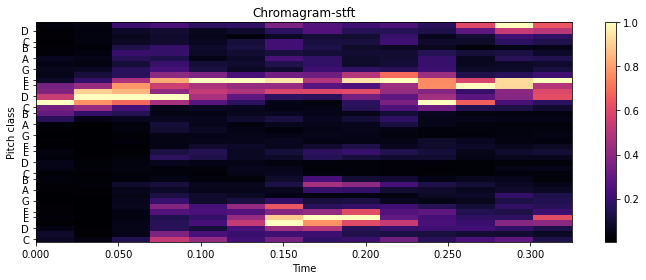

In [55]:
# Chroma_stft
chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram-stft')
plt.tight_layout()

In [56]:
y,sr=librosa.load("fold5/100032-3-0-0.wav")
mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
# tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sr).T,axis=0)
# melspectrogram.shape,chroma_stft.shape,contrast.shape,tonnetz.shape,mfccs.shape
mfccs.shape,melspectrogram.shape,chroma_stft.shape

((40,), (40,), (40,))

In [57]:
features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft)),(40,3))
features.shape

(40, 3)

In [60]:
x_train=[]
x_test=[]
y_train=[]
y_test=[]

path="fold"
for i in tqdm(range(len(df))):
    fold_no=str(df.iloc[i]["fold"])
    file=df.iloc[i]["slice_file_name"]
    label=df.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename)
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
    features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft)),(40,3))
    if(fold_no!='10'):
      x_train.append(features)
      y_train.append(label)
    else:
      x_test.append(features)
      y_test.append(label)


 41%|████      | 3555/8732 [24:11<36:18,  2.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
 95%|█████████▌| 8326/8732 [1:00:29<02:11,  3.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
 95%|█████████▌| 8329/8732 [1:00:30<02:07,  3.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
100%|██████████| 8732/8732 [1:03:09<00:00,  2.30it/s]


In [61]:
len(x_train)+len(x_test)

8732

In [62]:
x=x_train+x_test
y=y_train+y_test

In [63]:
x=np.array(x)
y=np.array(y)
x.shape,y.shape

((8732, 40, 3), (8732,))

In [64]:
x_2d=np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]))
x_2d.shape

np.savetxt("x.csv", x_2d, delimiter=",")
np.savetxt("y.csv",y,delimiter=",")


In [65]:
x_2d.shape

(8732, 120)

In [66]:
indexes = []
total = len(df)
indexes = list(range(0, total))


random.shuffle(indexes)

test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


X_test = np.take(x, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(x, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

test = df.iloc[test_split_idx]
train = df.iloc[train_split_idx]

print("Test split: {} \t\t Train split: {}".format(len(test), len(train)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 3) 	 X train shape: (6986, 40, 3)
y test shape: (1746,) 		 y train shape: (6986,)


In [67]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_train.shape,y_test.shape

((6986, 10), (1746, 10))

In [68]:
X_train=np.reshape(X_train,(X_train.shape[0], 40,3))
X_test=np.reshape(X_test,(X_test.shape[0], 40,3))
X_train.shape,X_test.shape



((6986, 40, 3), (1746, 40, 3))

In [69]:
X_train=np.reshape(X_train,(X_train.shape[0], 40,3,1))
X_test=np.reshape(X_test,(X_test.shape[0], 40,3,1))
X_train.shape,X_test.shape

((6986, 40, 3, 1), (1746, 40, 3, 1))

In [98]:
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout

model=Sequential()

model.add(Conv2D(64,kernel_size=3,strides=1,padding="Same",activation="relu",input_shape=(40,3,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=3,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(10,activation="softmax"))

In [99]:

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

history_relu=model.fit(X_train,y_train,batch_size=36,epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
195/195 [==============================] - 2s 6ms/step - loss: 2.2510 - accuracy: 0.1834 - val_loss: 1.9663 - val_accuracy: 0.3104
Epoch 2/100
195/195 [==============================] - 1s 5ms/step - loss: 1.9791 - accuracy: 0.2940 - val_loss: 1.7521 - val_accuracy: 0.3809
Epoch 3/100
195/195 [==============================] - 1s 5ms/step - loss: 1.7833 - accuracy: 0.3669 - val_loss: 1.6299 - val_accuracy: 0.4467
Epoch 4/100
195/195 [==============================] - 1s 5ms/step - loss: 1.6656 - accuracy: 0.4125 - val_loss: 1.5650 - val_accuracy: 0.4611
Epoch 5/100
195/195 [==============================] - 1s 5ms/step - loss: 1.6009 - accuracy: 0.4346 - val_loss: 1.4691 - val_accuracy: 0.4874
Epoch 6/100
195/195 [==============================] - 1s 5ms/step - loss: 1.5279 - accuracy: 0.4602 - val_loss: 1.3890 - val_accuracy: 0.5481
Epoch 7/100
195/195 [==============================] - 1s 5ms/step - loss: 1.4861 - accuracy: 0.4784 - val_loss: 1.4858 - val_accuracy: 0.4599

## 5. Evaluation 

In [100]:

train_loss_score=model.evaluate(X_train,y_train)
test_loss_score=model.evaluate(X_test,y_test)
print(train_loss_score)
print(test_loss_score)

55/55 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.8139
[0.2596750259399414, 0.9141139388084412]
[0.6751077175140381, 0.8138602375984192]


## 6. Result Analysis

In [101]:

y_probs = model.predict(X_test)

yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)

test['pred'] = yhat_probs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Confusion Matrix

In [103]:
np.set_printoptions(precision=2)

cm = confusion_matrix(y_trues, yhat_probs)
print(cm)            

[[177   0   8   0   3   2   0   1   3   2]
 [  2  67   5   2   2   3   0   0   5   4]
 [  6   1 136  10   4   7   3   3  19  15]
 [  1   1  14 141   7   3   1   1  18  13]
 [  5   0   5   6 156   0   2   9   2   3]
 [  2   0   5   0   0 179   0   1   3   0]
 [  1   0   7   0   3   0  51   0   3   3]
 [  0   0   3   0   5   0   2 206   1   1]
 [  0   0   4   4   1   6   1   0 162   0]
 [ 11   2  24  12  10   4   1   2   2 146]]


In [104]:
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.86      0.90      0.88       196
        Car Horn       0.94      0.74      0.83        90
Children Playing       0.64      0.67      0.66       204
        Dog bark       0.81      0.70      0.75       200
        Drilling       0.82      0.83      0.82       188
   Engine Idling       0.88      0.94      0.91       190
        Gun Shot       0.84      0.75      0.79        68
      Jackhammer       0.92      0.94      0.93       218
           Siren       0.74      0.91      0.82       178
    Street Music       0.78      0.68      0.73       214

        accuracy                           0.81      1746
       macro avg       0.82      0.81      0.81      1746
    weighted avg       0.82      0.81      0.81      1746



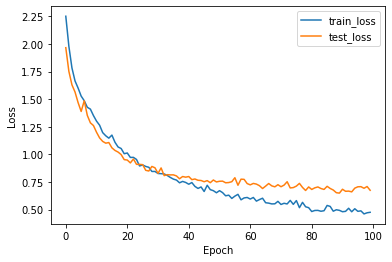

In [105]:
metrics = history_relu.history
plt.plot(history_relu.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

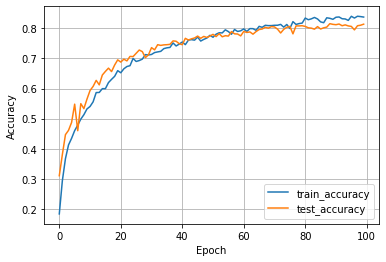

In [106]:

plt.plot(history_relu.history['accuracy'], label='train_accuracy')
plt.plot(history_relu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)